TensorFlow: 2.19.0
Num GPUs: 0
📤 请上传 1~3 个 CSV；若只传 1 个且含 ≥3 数值列，将取其前三列为 3 组。第一列必须为时间。


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (4).csv
✅ 收集到 3 组：
  1. equipment_degradation_timeseries_forecasting_dataset (4).csv::ds1_observed  (长度=5000)
  2. equipment_degradation_timeseries_forecasting_dataset (4).csv::ds2_observed  (长度=5000)
  3. equipment_degradation_timeseries_forecasting_dataset (4).csv::ds3_observed  (长度=5000)

📊 数据集 1: equipment_degradation_timeseries_forecasting_dataset (4).csv::ds1_observed
AutoTune: seq_len=55, units=(64,32), dropout=0.15, epochs=40, batch=128, period≈22
窗口形状：X_tr=(3545, 55, 1), X_va=(400, 55, 1), X_te=(1000, 55, 1)

Epoch 13: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 17: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 20: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 23: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


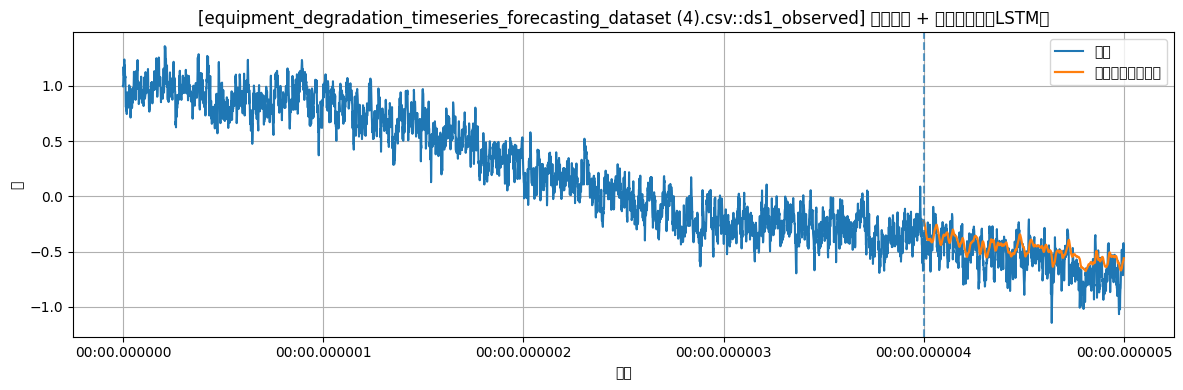


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 15: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 18: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 21: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.

Epoch 24: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.

Epoch 27: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.

Epoch 30: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.

Epoch 33: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.

Epoch 36: ReduceLROnPlateau reducing learning rate to 1e-06.


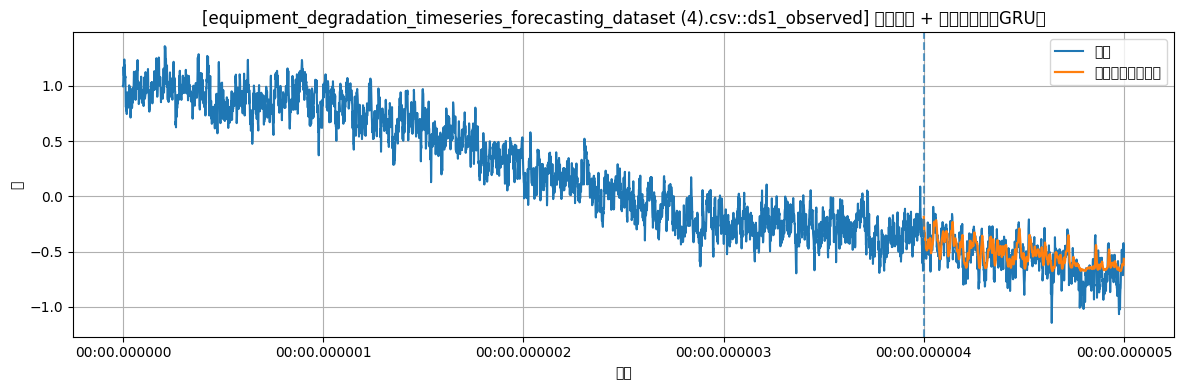


📊 数据集 2: equipment_degradation_timeseries_forecasting_dataset (4).csv::ds2_observed
AutoTune: seq_len=32, units=(64,32), dropout=0.15, epochs=40, batch=128, period≈13
窗口形状：X_tr=(3568, 32, 1), X_va=(400, 32, 1), X_te=(1000, 32, 1)

Epoch 17: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 20: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


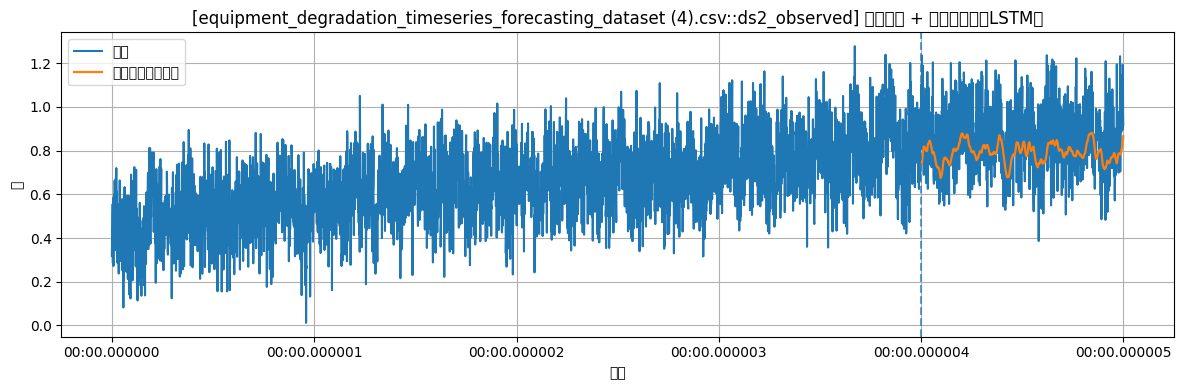


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


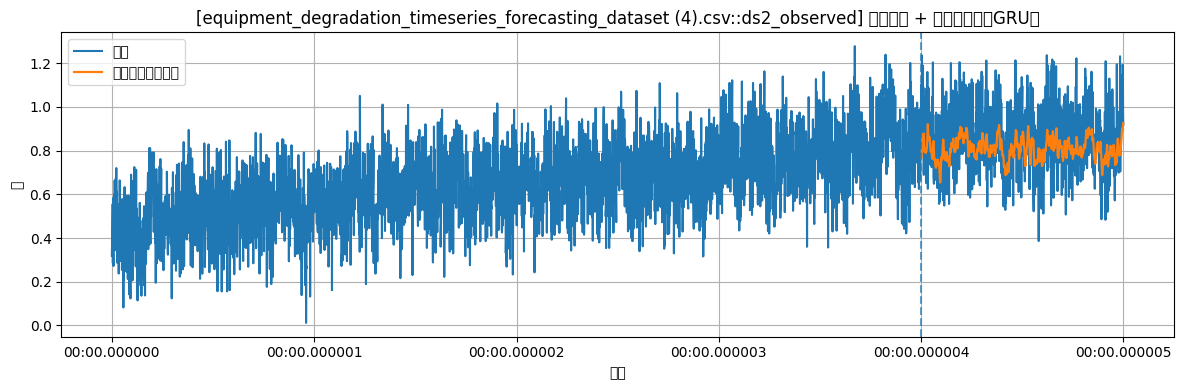


📊 数据集 3: equipment_degradation_timeseries_forecasting_dataset (4).csv::ds3_observed
AutoTune: seq_len=18, units=(64,32), dropout=0.15, epochs=40, batch=128, period≈7
窗口形状：X_tr=(3582, 18, 1), X_va=(400, 18, 1), X_te=(1000, 18, 1)

Epoch 14: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 17: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


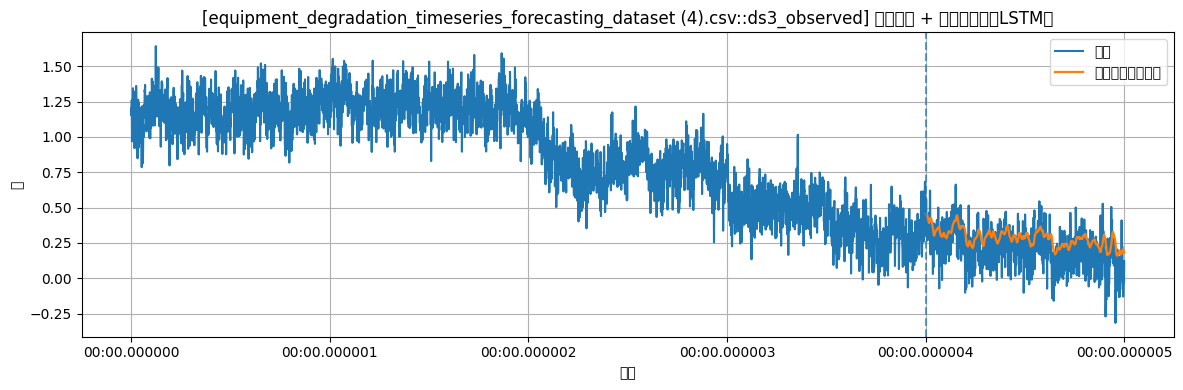


Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.


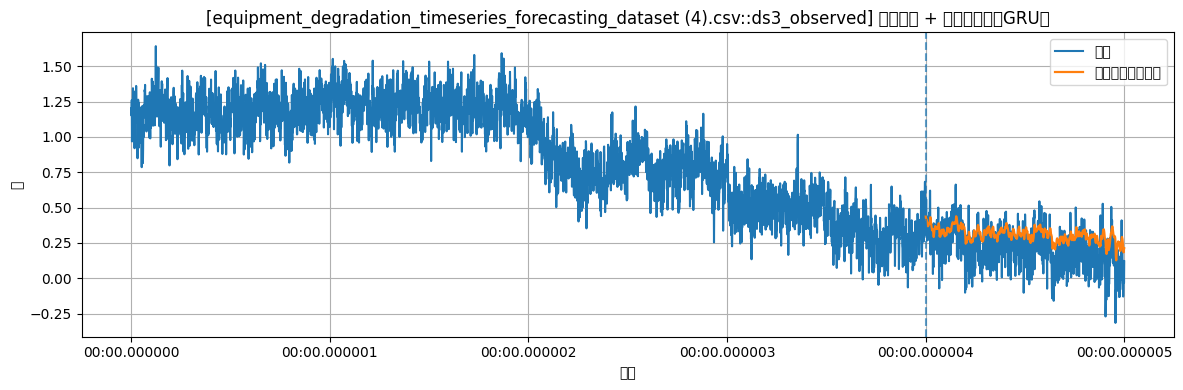


====== 各数据集 × 模型 的测试集指标（MAE / RMSE / R²）======
                                                                   Dataset Model      MAE     RMSE        R²
equipment_degradation_timeseries_forecasting_dataset (4).csv::ds1_observed   GRU 0.092833 0.118646  0.495909
equipment_degradation_timeseries_forecasting_dataset (4).csv::ds1_observed  LSTM 0.125098 0.156143  0.126922
equipment_degradation_timeseries_forecasting_dataset (4).csv::ds2_observed   GRU 0.122019 0.151586 -0.082343
equipment_degradation_timeseries_forecasting_dataset (4).csv::ds2_observed  LSTM 0.129174 0.160775 -0.217553
equipment_degradation_timeseries_forecasting_dataset (4).csv::ds3_observed   GRU 0.126156 0.156724 -0.298666
equipment_degradation_timeseries_forecasting_dataset (4).csv::ds3_observed  LSTM 0.113997 0.144085 -0.097639


In [ ]:
# %% [colab] — LSTM/GRU 时间序列预测（仅基于已有数据：训练/测试切分 + 测试集一步预测对比）
# 特点：
# 1) 第一列为时间轴；自动处理 1~3 组数据（单文件多列或多文件各一列）
# 2) 不做未来外推；只在测试集做逐点一步预测（walk-forward）
# 3) 针对数据长度与季节性自动调参（窗口、网络规模、epoch、batch）
# 4) 每个数据集 × 模型单独出图：整段“实际值” + 仅“测试段预测”；并标注测试起点
# 5) 最后打印 MAE/RMSE/R² 汇总表

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel('ERROR')
np.set_printoptions(suppress=True)

print("TensorFlow:", tf.__version__)
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))

# ====== 基础参数（其余按数据自动优化） ======
TEST_SIZE     = 0.20   # 测试集占比（按时间切分）
VAL_SIZE      = 0.10   # 训练内部验证集占比
MAX_DATASETS  = 3      # 最多处理 3 组
TARGET_COLS   = None   # 如需指定列名：["ds1","ds2","ds3"]；None=自动
RANDOM_SEED   = 42
FREQ_RESAMPLE = None   # e.g. "H","D","W"，None 保持原频率
PATIENCE      = 6      # 早停耐心
SHUFFLE_TRAIN = True   # 训练时是否打乱窗口

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ==================== 工具函数 ====================
def read_timeseries_csv(path, freq=None):
    """读取单个 CSV（首列为时间索引），仅保留数值列，按时间排序。"""
    df = pd.read_csv(path)
    if df.shape[1] < 2:
        raise ValueError(f"{path}: 需要至少两列（时间列 + 数值列）")
    tcol = df.columns[0]
    df[tcol] = pd.to_datetime(df[tcol], errors="coerce", infer_datetime_format=True)
    if df[tcol].isna().any():
        raise ValueError(f"{path}: 时间列解析失败")
    df = df.set_index(tcol).sort_index()
    if freq is not None:
        df = df.resample(freq).mean(numeric_only=True)
    df = df.select_dtypes(include=[np.number]).replace([np.inf,-np.inf],np.nan).ffill().bfill().dropna(how="any")
    return df

def time_split_series(y: pd.Series, test_size=0.2, val_size=0.1):
    """按时间切分：Series -> (train, val, test)。"""
    n = len(y)
    n_test = max(1, int(round(n * test_size)))
    n_trainval = n - n_test
    n_val = max(1, int(round(n_trainval * val_size)))
    n_train = max(1, n_trainval - n_val)
    train = y.iloc[:n_train]
    val   = y.iloc[n_train:n_train+n_val]
    test  = y.iloc[n_train+n_val:]
    return train, val, test

def quick_acf_period(x: np.ndarray, max_lag: int = 400, min_period: int = 6, threshold: float = 0.25):
    """估算主季节周期（简易 ACF 峰值）。返回周期或 None。"""
    x = np.asarray(x, dtype=float)
    x = x - x.mean()
    denom = np.dot(x, x) + 1e-12
    nlags = int(min(max_lag, max(10, len(x)//3)))
    acf = np.empty(nlags+1, dtype=float)
    acf[0] = 1.0
    for k in range(1, nlags+1):
        acf[k] = np.dot(x[:-k], x[k:]) / denom
    best_lag, best_val = None, 0.0
    for k in range(min_period, nlags-1):
        if acf[k] > threshold and acf[k] > acf[k-1] and acf[k] > acf[k+1]:
            if acf[k] > best_val:
                best_val, best_lag = acf[k], k
    return int(best_lag) if best_lag is not None else None

def choose_hparams(len_train: int, series: pd.Series):
    """基于训练集长度 + 粗略季节性估计，给出 seq_len、网络规模、epoch、batch。"""
    period = quick_acf_period(series.values, max_lag=min(800, len(series)//2))
    if period is not None:
        seq_len = int(np.clip(round(period * 2.5), 16, 512))
    else:
        if len_train < 300:   seq_len = 32
        elif len_train < 1000:seq_len = 64
        elif len_train < 3000:seq_len = 96
        else:                 seq_len = 128
    seq_len = int(np.clip(seq_len, 4, max(4, len_train-2)))

    if len_train < 500:
        units1, units2, drop = 32, 16, 0.1;  epochs = 80
    elif len_train < 2000:
        units1, units2, drop = 64, 32, 0.15; epochs = 60
    elif len_train < 6000:
        units1, units2, drop = 64, 32, 0.15; epochs = 40
    else:
        units1, units2, drop = 64, 32, 0.15; epochs = 25

    approx_windows = max(1, len_train - seq_len)
    bs_guess = max(32, 2 ** int(np.floor(np.log2(max(32, approx_windows//20)))))
    batch_size = int(min(256, bs_guess))

    return dict(seq_len=seq_len, units1=units1, units2=units2, dropout=drop,
                epochs=epochs, batch_size=batch_size, period=period)

def make_windows_1step(arr, seq_len):
    """缩放后的一维数组 -> 一步预测窗口：X:(N,seq_len,1), y:(N,1)"""
    X, y = [], []
    for i in range(len(arr) - seq_len):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len])
    X = np.array(X, dtype=np.float32).reshape(-1, seq_len, 1)
    y = np.array(y, dtype=np.float32).reshape(-1, 1)
    return X, y

# ===== GPU 混合精度（可提速） =====
if len(tf.config.list_physical_devices('GPU')) > 0:
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')
        print("→ Using mixed_float16 policy")
        FINAL_DTYPE = "float32"  # 最后一层输出强制回到 float32
    except Exception:
        FINAL_DTYPE = None
else:
    FINAL_DTYPE = None

def build_lstm(input_shape, units1=64, units2=32, dropout=0.15, lr=3e-4):
    out_dtype = FINAL_DTYPE if FINAL_DTYPE else None
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units1, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units2),
        layers.Dropout(dropout),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, dtype=out_dtype)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
    return model

def build_gru(input_shape, units1=64, units2=32, dropout=0.15, lr=3e-4):
    out_dtype = FINAL_DTYPE if FINAL_DTYPE else None
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(units1, return_sequences=True),
        layers.Dropout(dropout),
        layers.GRU(units2),
        layers.Dropout(dropout),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, dtype=out_dtype)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="mse",
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")])
    return model

def eval_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

# ✅ 关键：整段“实际值” + 仅“测试段预测”的绘图函数
def plot_full_with_test_pred(full_series: pd.Series, test_index, y_pred, title):
    """
    full_series: 全部真实序列 (train+val+test)
    test_index : 测试段的时间索引，与 y_pred 一一对应
    y_pred     : 仅测试段的预测值
    """
    plt.figure(figsize=(12,4))
    # 1) 全范围真实值
    plt.plot(full_series.index, full_series.values, label="实际", linewidth=1.5)
    # 2) 仅测试段预测
    plt.plot(test_index, y_pred, label="预测（仅测试段）", linewidth=1.6)
    # 3) 标出测试起点
    try:
        x0 = test_index[0]
        plt.axvline(x=x0, linestyle="--", alpha=0.7)
    except Exception:
        pass
    plt.title(title)
    plt.xlabel("时间"); plt.ylabel("值"); plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()

# ==================== 上传并收集最多三组数据 ====================
print("📤 请上传 1~3 个 CSV；若只传 1 个且含 ≥3 数值列，将取其前三列为 3 组。第一列必须为时间。")
uploaded = files.upload()
if not uploaded:
    raise SystemExit("未检测到文件上传。")

datasets = []  # 每项：(name, Series)

if len(uploaded) == 1:
    fname = list(uploaded.keys())[0]
    df = read_timeseries_csv(fname, freq=FREQ_RESAMPLE)
    num_cols = list(df.columns)

    if TARGET_COLS:
        cols = [c for c in TARGET_COLS if c in num_cols]
        if not cols:
            print("⚠️ TARGET_COLS 未命中任何列，自动选择前三个。")
            cols = num_cols[:MAX_DATASETS]
    else:
        cols = num_cols[:MAX_DATASETS]

    for c in cols[:MAX_DATASETS]:
        s = df[c].astype(float)
        datasets.append((f"{os.path.basename(fname)}::{c}", s))
else:
    for fname in list(uploaded.keys())[:MAX_DATASETS]:
        df = read_timeseries_csv(fname, freq=FREQ_RESAMPLE)
        target_col = df.columns[-1]
        s = df[target_col].astype(float)
        datasets.append((f"{os.path.basename(fname)}::{target_col}", s))

print(f"✅ 收集到 {len(datasets)} 组：")
for i,(nm,s) in enumerate(datasets,1):
    print(f"  {i}. {nm}  (长度={len(s)})")

# ==================== 逐组：自动调参 + 训练/预测/画“整段实测+测试预测” ====================
summary_rows = []

for ds_idx, (ds_name, series) in enumerate(datasets, 1):
    print("\n" + "="*90)
    print(f"📊 数据集 {ds_idx}: {ds_name}")

    # —— 时间切分（仅在已有数据内评估）——
    train_s, val_s, test_s = time_split_series(series, TEST_SIZE, VAL_SIZE)

    # —— 数据感知自动调参 ——
    hp = choose_hparams(len(train_s), train_s)
    seq_len   = hp["seq_len"]
    units1    = hp["units1"]
    units2    = hp["units2"]
    dropout   = hp["dropout"]
    EPOCHS    = hp["epochs"]
    BATCH_SIZE= hp["batch_size"]
    period    = hp["period"]

    print(f"AutoTune: seq_len={seq_len}, units=({units1},{units2}), dropout={dropout}, "
          f"epochs={EPOCHS}, batch={BATCH_SIZE}, period≈{period}")

    # —— 仅用训练集拟合缩放器（避免泄漏）——
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_s.values.reshape(-1,1)).reshape(-1)
    val_scaled   = scaler.transform(val_s.values.reshape(-1,1)).reshape(-1)
    test_scaled  = scaler.transform(test_s.values.reshape(-1,1)).reshape(-1)

    # 训练/验证/测试 窗口（一步预测）
    X_tr, y_tr = make_windows_1step(train_scaled, seq_len)
    tr_tail_plus_val = np.concatenate([train_scaled[-seq_len:], val_scaled])
    X_va, y_va = make_windows_1step(tr_tail_plus_val, seq_len)
    tr_tail_plus_test = np.concatenate([train_scaled[-seq_len:], test_scaled])
    X_te, y_te_scaled = make_windows_1step(tr_tail_plus_test, seq_len)

    # 反缩放得到与测试集一一对应的真实 y 及索引
    y_te = scaler.inverse_transform(y_te_scaled).reshape(-1)
    test_index = test_s.index

    print(f"窗口形状：X_tr={X_tr.shape}, X_va={X_va.shape}, X_te={X_te.shape}")

    # —— 训练 LSTM ——
    lstm = build_lstm((seq_len,1), units1=units1, units2=units2, dropout=dropout, lr=3e-4)
    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=max(2,PATIENCE//2),
                                    min_lr=1e-6, verbose=1)
    ]
    lstm.fit(X_tr, y_tr, validation_data=(X_va, y_va),
             epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN,
             verbose=0, callbacks=cbs)

    yhat_lstm_scaled = lstm.predict(X_te, verbose=0).reshape(-1,1)
    yhat_lstm = scaler.inverse_transform(yhat_lstm_scaled).reshape(-1)

    mae, rmse, r2 = eval_metrics(y_te, yhat_lstm)
    summary_rows.append([ds_name, "LSTM", mae, rmse, r2])

    # —— 单独作图（整段实际 + 仅测试预测）——
    plot_full_with_test_pred(
        full_series=series,
        test_index=test_index,
        y_pred=yhat_lstm,
        title=f"[{ds_name}] 整段实际 + 测试段预测（LSTM）"
    )

    # —— 训练 GRU ——
    gru = build_gru((seq_len,1), units1=units1, units2=units2, dropout=dropout, lr=3e-4)
    gru.fit(X_tr, y_tr, validation_data=(X_va, y_va),
            epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=SHUFFLE_TRAIN,
            verbose=0, callbacks=cbs)

    yhat_gru_scaled = gru.predict(X_te, verbose=0).reshape(-1,1)
    yhat_gru = scaler.inverse_transform(yhat_gru_scaled).reshape(-1)

    mae, rmse, r2 = eval_metrics(y_te, yhat_gru)
    summary_rows.append([ds_name, "GRU", mae, rmse, r2])

    plot_full_with_test_pred(
        full_series=series,
        test_index=test_index,
        y_pred=yhat_gru,
        title=f"[{ds_name}] 整段实际 + 测试段预测（GRU）"
    )

# ==================== 汇总表 ====================
summary = pd.DataFrame(summary_rows, columns=["Dataset", "Model", "MAE", "RMSE", "R²"])
summary = summary.sort_values(by=["Dataset","Model"]).reset_index(drop=True)

pd.set_option('display.float_format', lambda x: f"{x:,.6f}")
print("\n====== 各数据集 × 模型 的测试集指标（MAE / RMSE / R²）======")
print(summary.to_string(index=False))

TensorFlow: 2.19.0
Num GPUs: 0
📤 请上传 1~3 个 CSV；若只传 1 个且含 ≥3 数值列，将取其前三列为 3 组。第一列必须为时间。


Saving equipment_degradation_timeseries_forecasting_dataset.csv to equipment_degradation_timeseries_forecasting_dataset (9).csv
✅ 收集到 3 组（预处理方法：savgol_centered）

📊 数据集 1: equipment_degradation_timeseries_forecasting_dataset (9).csv::ds1_observed_underlying  长度=5000
AutoTune: seq_len=54, stride=1, units=(64,32), dropout=0.15, epochs=25, batch=128
窗口数: train=3546, val=400, test=1000

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 7: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 8: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


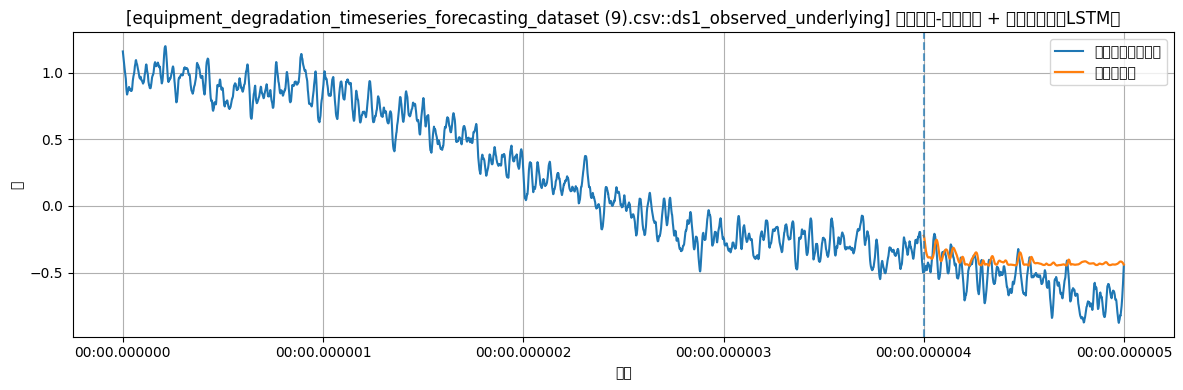


Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 3: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 4: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.


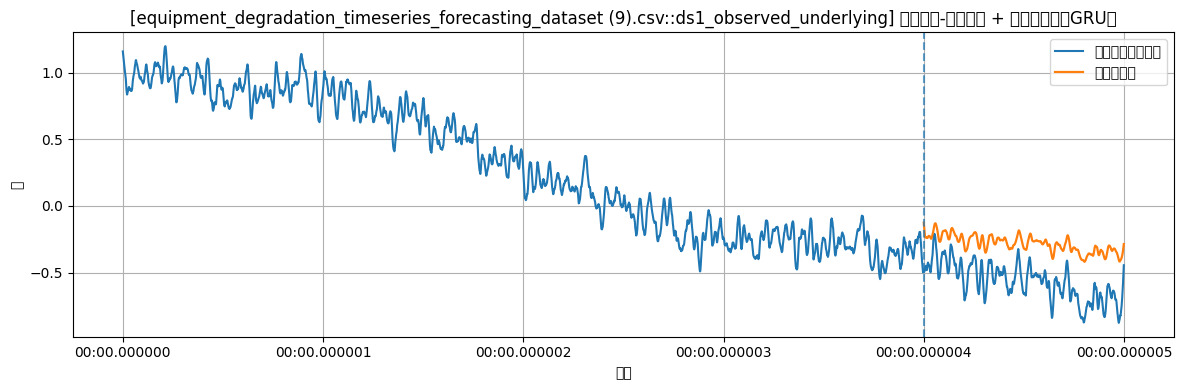


📊 数据集 2: equipment_degradation_timeseries_forecasting_dataset (9).csv::ds2_observed_underlying  长度=5000
AutoTune: seq_len=256, stride=1, units=(64,32), dropout=0.15, epochs=25, batch=128
窗口数: train=3344, val=400, test=1000

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 10: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 12: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.

Epoch 15: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.

Epoch 16: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.

Epoch 17: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.


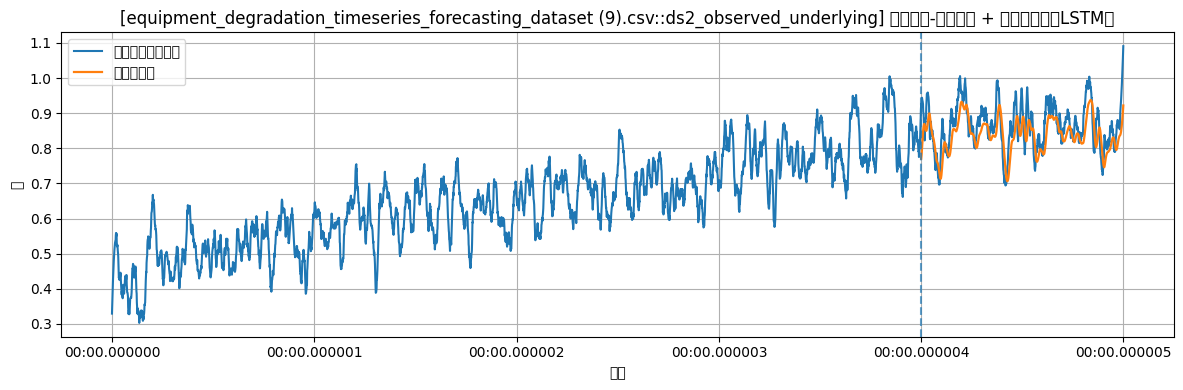


Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 4: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 5: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 6: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.


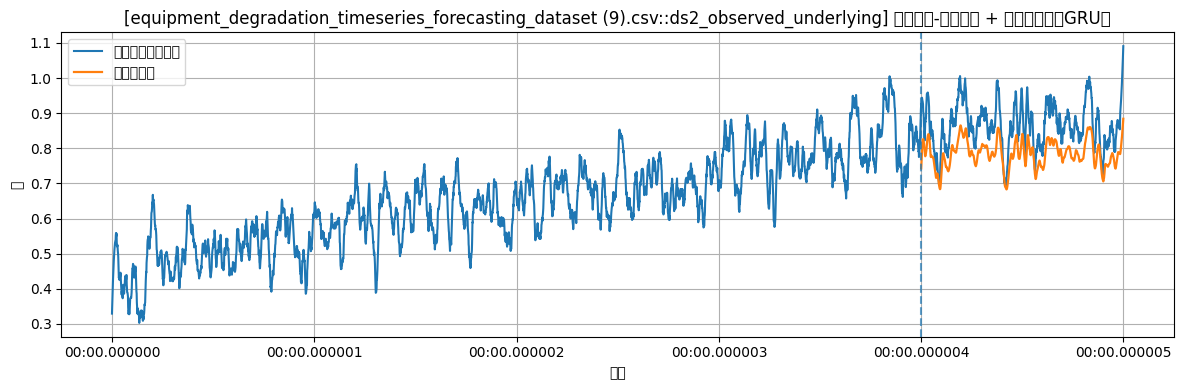


📊 数据集 3: equipment_degradation_timeseries_forecasting_dataset (9).csv::ds3_observed_underlying  长度=5000
AutoTune: seq_len=96, stride=1, units=(64,32), dropout=0.15, epochs=25, batch=128
窗口数: train=3504, val=400, test=1000

Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 10: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.

Epoch 17: ReduceLROnPlateau reducing learning rate to 1e-06.


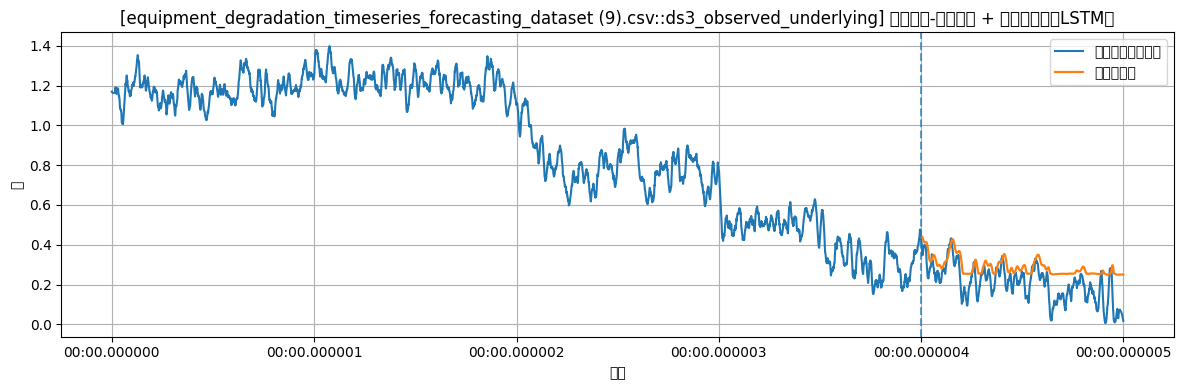


Epoch 9: ReduceLROnPlateau reducing learning rate to 0.0001500000071246177.

Epoch 10: ReduceLROnPlateau reducing learning rate to 7.500000356230885e-05.

Epoch 11: ReduceLROnPlateau reducing learning rate to 3.7500001781154424e-05.

Epoch 12: ReduceLROnPlateau reducing learning rate to 1.8750000890577212e-05.

Epoch 13: ReduceLROnPlateau reducing learning rate to 9.375000445288606e-06.

Epoch 14: ReduceLROnPlateau reducing learning rate to 4.687500222644303e-06.

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.3437501113221515e-06.

Epoch 16: ReduceLROnPlateau reducing learning rate to 1.1718750556610757e-06.

Epoch 17: ReduceLROnPlateau reducing learning rate to 1e-06.


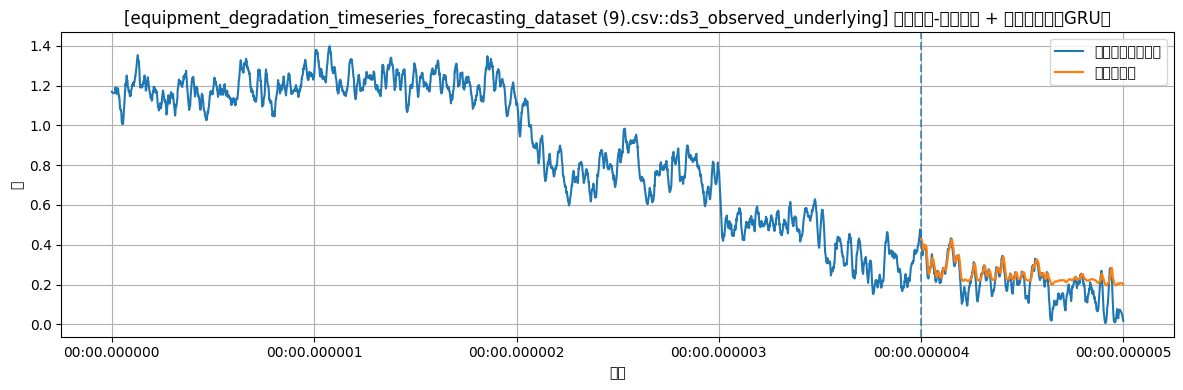


====== 各数据集 × 模型（预处理后目标）的测试集指标 ======
                                                                              Dataset               Model      MAE     RMSE        R²
equipment_degradation_timeseries_forecasting_dataset (9).csv::ds1_observed_underlying  GRU (preprocessed) 0.283283 0.294758 -3.588180
equipment_degradation_timeseries_forecasting_dataset (9).csv::ds1_observed_underlying LSTM (preprocessed) 0.161318 0.196242 -1.033715
equipment_degradation_timeseries_forecasting_dataset (9).csv::ds2_observed_underlying  GRU (preprocessed) 0.080246 0.087412 -0.828655
equipment_degradation_timeseries_forecasting_dataset (9).csv::ds2_observed_underlying LSTM (preprocessed) 0.043060 0.053278  0.320667
equipment_degradation_timeseries_forecasting_dataset (9).csv::ds3_observed_underlying  GRU (preprocessed) 0.052152 0.071416  0.360524
equipment_degradation_timeseries_forecasting_dataset (9).csv::ds3_observed_underlying LSTM (preprocessed) 0.084295 0.103833 -0.351769


In [ ]:
# %% [colab] — LSTM/GRU on PREPROCESSED (underlying) data, FAST & ROBUST
# - 预处理提取 underlying (默认 Savitzky–Golay)
# - 仅训练/测试切分内评估；测试段一步预测；图上“整段真实(预处理后)+仅测试段预测”
# - 多数据集(≤3)；输出 MAE/RMSE/R² 总表
# - 大幅加速：自适应窗口降采样、轻量网络、早停、混合精度、XLA、tf.data

import os, math, warnings
warnings.filterwarnings("ignore")

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from google.colab import files
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, optimizers

# 预处理
from scipy.signal import savgol_filter
# 注：若要低斯 LOWESS，可取消下一行注释并把 PREPROCESS_METHOD 改成 "lowess_centered"
# !pip -q install statsmodels --upgrade
# from statsmodels.nonparametric.smoothers_lowess import lowess

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
tf.get_logger().setLevel('ERROR')
np.set_printoptions(suppress=True)

print("TensorFlow:", tf.__version__)
print("Num GPUs:", len(tf.config.list_physical_devices('GPU')))

# ===== 基础与加速参数 =====
TEST_SIZE      = 0.20
VAL_SIZE       = 0.10
MAX_DATASETS   = 3
TARGET_COLS    = None        # 例如 ["ds1","ds2","ds3"]；None=自动
RANDOM_SEED    = 42
FREQ_RESAMPLE  = None        # "H"/"D"/"W"；None=保持原频率
PATIENCE       = 3           # 更激进的早停
SHUFFLE_TRAIN  = True

# 预处理（提取 underlying）
PREPROCESS_METHOD = "savgol_centered"   # "savgol_centered" / "moving_causal" / "lowess_centered"
SAVGOL_WINDOW     = 31                   # 奇数
SAVGOL_POLY       = 2
MOVING_WINDOW     = 15                   # 因果移动平均窗口
# LOWESS_FRAC     = 0.02                # 启用 lowess 时再加

# 训练规模上限（控制速度）
MAX_WINDOWS_PER_SET = 5000              # 每个数据集最多用于训练的窗口数（越小越快）
MAX_BATCH_SIZE      = 128               # 保守的上限，防OOM

tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

# ===== 开启 GPU 混合精度与 XLA（有 GPU 时）=====
if len(tf.config.list_physical_devices('GPU')) > 0:
    try:
        from tensorflow.keras import mixed_precision
        mixed_precision.set_global_policy('mixed_float16')
        print("→ Using mixed_float16")
        FINAL_DTYPE = "float32"
    except Exception:
        FINAL_DTYPE = None
else:
    FINAL_DTYPE = None

tf.config.optimizer.set_jit(True)  # XLA

# ==================== 工具函数 ====================
def read_timeseries_csv(path, freq=None):
    df = pd.read_csv(path)
    if df.shape[1] < 2:
        raise ValueError(f"{path}: 需要至少两列（时间 + 数值）")
    tcol = df.columns[0]
    df[tcol] = pd.to_datetime(df[tcol], errors="coerce", infer_datetime_format=True)
    if df[tcol].isna().any():
        raise ValueError(f"{path}: 时间列解析失败")
    df = df.set_index(tcol).sort_index()
    if freq is not None:
        df = df.resample(freq).mean(numeric_only=True)
    df = df.select_dtypes(include=[np.number]).replace([np.inf,-np.inf],np.nan).ffill().bfill().dropna(how="any")
    return df

def preprocess_signal(y: pd.Series, method="savgol_centered"):
    idx = y.index
    x = y.values.astype(float)
    if method == "savgol_centered":
        wl = max(5, int(SAVGOL_WINDOW) | 1)  # 奇数
        po = max(1, int(SAVGOL_POLY))
        xhat = savgol_filter(x, wl, po)
    elif method == "moving_causal":
        wl = max(2, int(MOVING_WINDOW))
        w = np.ones(wl, dtype=float) / wl
        xhat = np.convolve(x, w, mode="full")[:len(x)]
        pad = wl-1
        if pad > 0:
            xhat[:pad] = xhat[pad]
    elif method == "lowess_centered":
        from statsmodels.nonparametric.smoothers_lowess import lowess
        frac = 0.02
        xhat = lowess(x, np.arange(len(x)), frac=frac, return_sorted=False)
    else:
        raise ValueError("Unknown preprocess method")
    return pd.Series(xhat, index=idx, name=y.name + "_underlying")

def time_split_series(y: pd.Series, test_size=0.2, val_size=0.1):
    n = len(y)
    n_test = max(1, int(round(n * test_size)))
    n_trainval = n - n_test
    n_val = max(1, int(round(n_trainval * val_size)))
    n_train = max(1, n_trainval - n_val)
    return y.iloc[:n_train], y.iloc[n_train:n_train+n_val], y.iloc[n_train+n_val:]

def quick_acf_period(x: np.ndarray, max_lag: int = 400, min_period: int = 6, threshold: float = 0.25):
    x = np.asarray(x, dtype=float) - np.mean(x)
    denom = np.dot(x, x) + 1e-12
    nlags = int(min(max_lag, max(10, len(x)//3)))
    acf = np.empty(nlags+1, dtype=float); acf[0] = 1.0
    for k in range(1, nlags+1):
        acf[k] = np.dot(x[:-k], x[k:]) / denom
    best_lag, best_val = None, 0.0
    for k in range(min_period, nlags-1):
        if acf[k] > threshold and acf[k] > acf[k-1] and acf[k] > acf[k+1]:
            if acf[k] > best_val:
                best_val, best_lag = acf[k], k
    return int(best_lag) if best_lag is not None else None

def choose_hparams(len_train: int, series: pd.Series):
    period = quick_acf_period(series.values, max_lag=min(800, len(series)//2))
    if period is not None:
        seq_len = int(np.clip(round(period * 2.0), 16, 256))
    else:
        seq_len = 32 if len_train < 300 else 64 if len_train < 1200 else 96
    seq_len = int(np.clip(seq_len, 4, max(4, len_train-2)))

    # 轻量网络
    if len_train < 800:
        units1, units2, drop = 32, 16, 0.1;  epochs = 40
    elif len_train < 3000:
        units1, units2, drop = 48, 24, 0.15; epochs = 30
    else:
        units1, units2, drop = 64, 32, 0.15; epochs = 25

    # 估计窗口数，确定 batch 与 stride
    approx_windows = max(1, len_train - seq_len)
    # 自适应 stride：保证窗口不超过上限
    stride = max(1, int(np.ceil(approx_windows / MAX_WINDOWS_PER_SET)))
    # 批大小保守，防 OOM
    bs_guess = max(32, 2 ** int(np.floor(np.log2(max(32, approx_windows//20)))))
    batch_size = int(min(MAX_BATCH_SIZE, bs_guess))
    return dict(seq_len=seq_len, units1=units1, units2=units2, dropout=drop,
                epochs=epochs, batch_size=batch_size, stride=stride, period=period)

def make_windows_stride(arr, seq_len, stride=1):
    # 产生步长为 stride 的窗口（大幅减小样本数，加速训练）
    X, y = [], []
    end = len(arr) - seq_len
    for i in range(0, end, stride):
        X.append(arr[i:i+seq_len])
        y.append(arr[i+seq_len])
    X = np.array(X, dtype=np.float32).reshape(-1, seq_len, 1)
    y = np.array(y, dtype=np.float32).reshape(-1, 1)
    return X, y

def to_dataset(X, y, batch, shuffle):
    ds = tf.data.Dataset.from_tensor_slices((X, y))
    if shuffle:
        ds = ds.shuffle(min(10000, len(X)), seed=RANDOM_SEED, reshuffle_each_iteration=True)
    return ds.batch(batch, drop_remainder=False).prefetch(tf.data.AUTOTUNE)

def build_lstm(input_shape, units1=48, units2=24, dropout=0.15, lr=3e-4):
    out_dtype = "float32" if FINAL_DTYPE else None
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.LSTM(units1, return_sequences=True),
        layers.Dropout(dropout),
        layers.LSTM(units2),
        layers.Dropout(dropout),
        layers.Dense(24, activation="relu"),
        layers.Dense(1, dtype=out_dtype)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
                  jit_compile=True)
    return model

def build_gru(input_shape, units1=48, units2=24, dropout=0.15, lr=3e-4):
    out_dtype = "float32" if FINAL_DTYPE else None
    model = models.Sequential([
        layers.Input(shape=input_shape),
        layers.GRU(units1, return_sequences=True),
        layers.Dropout(dropout),
        layers.GRU(units2),
        layers.Dropout(dropout),
        layers.Dense(24, activation="relu"),
        layers.Dense(1, dtype=out_dtype)
    ])
    model.compile(optimizer=optimizers.Adam(learning_rate=lr),
                  loss="mse", metrics=[tf.keras.metrics.MeanAbsoluteError(name="mae")],
                  jit_compile=True)
    return model

def eval_metrics(y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = math.sqrt(mean_squared_error(y_true, y_pred))
    r2   = r2_score(y_true, y_pred)
    return mae, rmse, r2

def plot_full_with_test_pred(full_series: pd.Series, test_index, y_pred, title):
    plt.figure(figsize=(12,4))
    plt.plot(full_series.index, full_series.values, label="预处理后的实际值", linewidth=1.5)
    plt.plot(test_index, y_pred, label="测试段预测", linewidth=1.6)
    try: plt.axvline(x=test_index[0], linestyle="--", alpha=0.7)
    except: pass
    plt.title(title); plt.xlabel("时间"); plt.ylabel("值"); plt.grid(True); plt.legend()
    plt.tight_layout(); plt.show()

# ==================== 上传并构建最多三组“预处理后的”数据 ====================
print("📤 请上传 1~3 个 CSV；若只传 1 个且含 ≥3 数值列，将取其前三列为 3 组。第一列必须为时间。")
uploaded = files.upload()
if not uploaded: raise SystemExit("未检测到文件上传。")

datasets = []  # (name, Series_preprocessed)
if len(uploaded) == 1:
    fname = list(uploaded.keys())[0]
    df = read_timeseries_csv(fname, freq=FREQ_RESAMPLE)
    cols = (TARGET_COLS if TARGET_COLS else list(df.columns[:MAX_DATASETS]))
    cols = [c for c in cols if c in df.columns][:MAX_DATASETS]
    for c in cols:
        s_smooth = preprocess_signal(df[c].astype(float), method=PREPROCESS_METHOD)
        datasets.append((f"{os.path.basename(fname)}::{c}_underlying", s_smooth))
else:
    for fname in list(uploaded.keys())[:MAX_DATASETS]:
        df = read_timeseries_csv(fname, freq=FREQ_RESAMPLE)
        col = df.columns[-1]
        s_smooth = preprocess_signal(df[col].astype(float), method=PREPROCESS_METHOD)
        datasets.append((f"{os.path.basename(fname)}::{col}_underlying", s_smooth))

print(f"✅ 收集到 {len(datasets)} 组（预处理方法：{PREPROCESS_METHOD}）")

# ==================== 训练/测试/绘图/评估 ====================
summary_rows = []

for ds_idx, (ds_name, series_proc) in enumerate(datasets, 1):
    print("\n" + "="*90)
    print(f"📊 数据集 {ds_idx}: {ds_name}  长度={len(series_proc)}")

    # 切分（仅已有数据范围）
    train_s, val_s, test_s = time_split_series(series_proc, TEST_SIZE, VAL_SIZE)

    # 自动调参 + 自适应 stride
    hp = choose_hparams(len(train_s), train_s)
    seq_len, units1, units2 = hp["seq_len"], hp["units1"], hp["units2"]
    dropout, EPOCHS = hp["dropout"], hp["epochs"]
    BATCH_SIZE, STRIDE = hp["batch_size"], hp["stride"]

    print(f"AutoTune: seq_len={seq_len}, stride={STRIDE}, units=({units1},{units2}), "
          f"dropout={dropout}, epochs={EPOCHS}, batch={BATCH_SIZE}")

    # 缩放（仅用训练拟合）
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_s.values.reshape(-1,1)).reshape(-1)
    val_scaled   = scaler.transform(val_s.values.reshape(-1,1)).reshape(-1)
    test_scaled  = scaler.transform(test_s.values.reshape(-1,1)).reshape(-1)

    # 窗口（使用 stride 降采样）
    X_tr, y_tr = make_windows_stride(train_scaled, seq_len, stride=STRIDE)
    tr_plus_val = np.concatenate([train_scaled[-seq_len:], val_scaled])
    X_va, y_va = make_windows_stride(tr_plus_val, seq_len, stride=max(1, STRIDE))
    tr_plus_test = np.concatenate([train_scaled[-seq_len:], test_scaled])
    X_te, y_te_scaled = make_windows_stride(tr_plus_test, seq_len, stride=1)  # 测试保持逐点

    # 还原到“预处理后的实际值”尺度
    y_te = scaler.inverse_transform(y_te_scaled).reshape(-1)
    test_index = test_s.index

    print(f"窗口数: train={len(X_tr)}, val={len(X_va)}, test={len(X_te)}")

    # tf.data 管道
    ds_tr = to_dataset(X_tr, y_tr, BATCH_SIZE, SHUFFLE_TRAIN)
    ds_va = to_dataset(X_va, y_va, BATCH_SIZE, False)

    # -------- LSTM --------
    lstm = build_lstm((seq_len,1), units1=units1, units2=units2, dropout=dropout, lr=3e-4)
    cbs = [
        callbacks.EarlyStopping(monitor="val_loss", patience=PATIENCE, restore_best_weights=True),
        callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=max(1,PATIENCE//2),
                                    min_lr=1e-6, verbose=1)
    ]
    lstm.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS, verbose=0, callbacks=cbs)

    yhat_lstm_scaled = lstm.predict(X_te, verbose=0).reshape(-1,1)
    yhat_lstm = scaler.inverse_transform(yhat_lstm_scaled).reshape(-1)

    mae, rmse, r2 = eval_metrics(y_te, yhat_lstm)
    summary_rows.append([ds_name, "LSTM (preprocessed)", mae, rmse, r2])

    plot_full_with_test_pred(series_proc, test_index, yhat_lstm,
                             title=f"[{ds_name}] 预处理后-整段实际 + 测试段预测（LSTM）")

    # -------- GRU --------
    gru = build_gru((seq_len,1), units1=units1, units2=units2, dropout=dropout, lr=3e-4)
    gru.fit(ds_tr, validation_data=ds_va, epochs=EPOCHS, verbose=0, callbacks=cbs)

    yhat_gru_scaled = gru.predict(X_te, verbose=0).reshape(-1,1)
    yhat_gru = scaler.inverse_transform(yhat_gru_scaled).reshape(-1)

    mae, rmse, r2 = eval_metrics(y_te, yhat_gru)
    summary_rows.append([ds_name, "GRU (preprocessed)", mae, rmse, r2])

    plot_full_with_test_pred(series_proc, test_index, yhat_gru,
                             title=f"[{ds_name}] 预处理后-整段实际 + 测试段预测（GRU）")

# ===== 汇总表 =====
summary = pd.DataFrame(summary_rows, columns=["Dataset", "Model", "MAE", "RMSE", "R²"]).sort_values(["Dataset","Model"])
pd.set_option('display.float_format', lambda x: f"{x:,.6f}")
print("\n====== 各数据集 × 模型（预处理后目标）的测试集指标 ======")
print(summary.to_string(index=False))